# TPCRP Algorithm Implementation

In [47]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets
from torch.utils.data import DataLoader
from scipy.spatial.distance import cdist

# Feature Extraction

In [48]:
# Load Official Weights & Transforms
weights = ResNet18_Weights.DEFAULT
resnet_transforms = weights.transforms()

# Preprocessing 
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),  # Resizing to match ResNet
    transforms.CenterCrop(224),  # Cropping to 224x224 as required by ResNet
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Correct Normalization
])

# Load CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

# Load Pretrained ResNet18 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(weights=weights).to(device)
model.fc = torch.nn.Identity()  # Remove classification layer
model.eval()  # Set to evaluation mode

# Print model summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Use the pre-trained **ResNet18** model to extract feature embeddings.

In [49]:
def extract_features(data_loader, model, device="cuda"):
    model.to(device)
    model.eval()
    features = []
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)  # Move images to GPU
            output = model(images)
            features.append(output.cpu().numpy())  # Move back to CPU for clustering
            
    return np.vstack(features)

features = extract_features(train_loader, model)

# K-Means Clustering

In [50]:
L_size = 50   # Number of already labeled examples (|L|)
B = 20        # Budget (New samples to be labeled)
num_clusters = L_size + B


# K-Means Clustering 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(features)

# Selecting Typical Examples

In [51]:
def select_typical_examples(features, labels):
    """Compute Typicality using all points in the same cluster"""
    selected_indices = []
    
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_features = features[cluster_indices]
        
        # Compute pairwise distances within the cluster
        distances = cdist(cluster_features, cluster_features, metric="euclidean")
        
        # Compute Typicality: (1 / Mean Distance to All Other Points in Cluster)
        typicality_scores = np.reciprocal(np.mean(distances, axis=1))
        
        # Select the most typical sample (highest typicality score)
        best_index = cluster_indices[np.argmax(typicality_scores)]
        selected_indices.append(best_index)
    
    return selected_indices

selected_samples = select_typical_examples(features, labels)
print("Selected sample indices:", selected_samples)

Selected sample indices: [np.int64(2129), np.int64(14787), np.int64(9978), np.int64(31449), np.int64(15979), np.int64(23841), np.int64(19102), np.int64(27487), np.int64(20614), np.int64(31419), np.int64(18057), np.int64(11206), np.int64(34578), np.int64(44384), np.int64(37944), np.int64(30539), np.int64(12096), np.int64(16996), np.int64(46374), np.int64(22231), np.int64(16114), np.int64(20776), np.int64(2317), np.int64(19019), np.int64(39150), np.int64(6817), np.int64(9264), np.int64(33076), np.int64(15089), np.int64(14155), np.int64(2581), np.int64(19772), np.int64(49757), np.int64(24308), np.int64(26839), np.int64(8313), np.int64(22130), np.int64(8055), np.int64(6788), np.int64(42853), np.int64(4916), np.int64(11446), np.int64(31078), np.int64(21775), np.int64(46053), np.int64(47942), np.int64(12325), np.int64(28619), np.int64(6088), np.int64(20443), np.int64(44307), np.int64(18507), np.int64(19315), np.int64(8400), np.int64(22889), np.int64(4713), np.int64(9228), np.int64(14577), np

# Visualisation

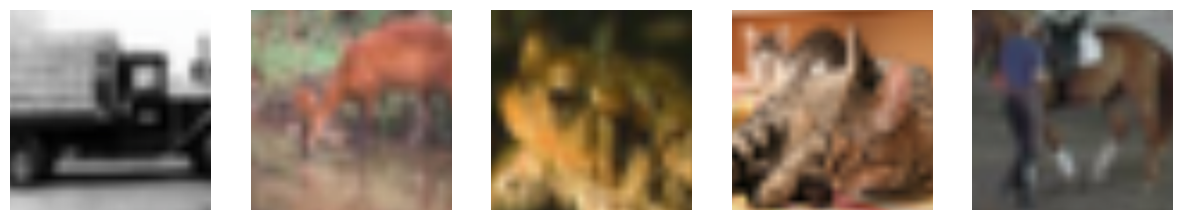

In [58]:
def show_images(dataset, indices, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Show images after denormalization"""
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    for ax, idx in zip(axes, indices):
        image, _ = dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
        image = image * std + mean  # De-normalize
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.axis('off')
    plt.show()

show_images(train_dataset, selected_samples[:5])